# git2net analysis for the networkx repository

First we import the required packages

In [28]:
import pygit2 as git2
import os
import shutil
import git2net
import pathpy as pp
import sqlite3
import pandas as pd
from datetime import date, datetime, timedelta
import datetime as dt
import matplotlib.pyplot as plt
import json 
import math
import copy
import networkx

git_repo_url = 'https://github.com/pandas-dev/pandas.git'
#git_repo_url = 'https://github.com/networkx/networkx.git'
#git_repo_url = 'https://github.com/numpy/numpy.git'
#git_repo_url = 'https://github.com/deepcharles/ruptures.git'
#git_repo_url = 'https://github.com/mwaskom/seaborn.git'
repo_name = 'networkx'
local_directory = '.'
git_repo_dir = 'repos/{r}4analysis'.format(r=repo_name)
sqlite_db_file = 'databases/{r}/{r}_rename.db'.format(r=repo_name)
#sqlite_db_file = 'databases/{r}/{r}.db'.format(r=repo_name)

Clone repo:

In [ ]:
if os.path.exists(git_repo_dir):
    shutil.rmtree(git_repo_dir)

repo = git2.clone_repository(git_repo_url, git_repo_dir) # Clones a non-bare repository

Then we create the database for it. We will try with max_modification=100, so that most commits are processed.

Mine repo:

In [ ]:
# Remove database if exists
#if os.path.exists(sqlite_db_file):
#    os.remove(sqlite_db_file)

max_modifications = 100
    
git2net.mine_git_repo(git_repo_dir, sqlite_db_file, max_modifications=max_modifications)

Let's check the commits that had more than 100 files modified

In [ ]:
git2net.mining_state_summary(git_repo_dir, sqlite_db_file)

### Database modification
Replacing the duplicate names, then the names with numbers for compatibility with a temporal network.

In [ ]:
con = sqlite3.connect(sqlite_db_file)

# Query the db
data = pd.read_sql("""SELECT * FROM commits""", con)
data

In [ ]:
con = sqlite3.connect(sqlite_db_file)

# Query the db
data = pd.read_sql("""SELECT * FROM commits""", con)
data[['author_name', 'author_email']].drop_duplicates().sort_values(by=['author_name', 'author_email']).to_excel('databases/{r}/{r}_commits_authors.xlsx'.format(r=repo_name))
data[['committer_name', 'committer_email']].drop_duplicates().sort_values(by=['committer_name', 'committer_email']).to_excel('databases/{r}/{r}_commits_committers.xlsx'.format(r=repo_name))

In [ ]:
con = sqlite3.connect(sqlite_db_file)

# Query the db
data = pd.read_sql("""SELECT * FROM commits""", con)
data[['author_name', 'author_email']].drop_duplicates().sort_values(by=['author_name', 'author_email']).to_excel('databases/{r}/{r}_commits_authors.xlsx'.format(r=repo_name))
data[['committer_name', 'committer_email']].drop_duplicates().sort_values(by=['committer_name', 'committer_email']).to_excel('databases/{r}/{r}_commits_committers.xlsx'.format(r=repo_name))

#with open('aliases/aliases-{r}.json'.format(r=repo_name)) as f:
#    aliases = json.load(f)
#    data = data.replace({'author_name': aliases})
#    data = data.replace({'committer_name': aliases})
#f.close()

rename_auth = {}
rename_committer = {}

i = 1
for name in data['author_name'].unique():
    rename_auth[name] = str(i)
    i = i + 1

i = 1
for name in data['committer_name'].unique():
    rename_committer[name] = str(i)
    i = i + 1

data = data.replace({'author_name': rename_auth})
data = data.replace({'committer_name': rename_committer})

#f = open('databases/{r}/{r}_authors.json'.format(r=repo_name), 'w')
#f.write(json.dumps(rename_auth))
#f.close()

#f = open('databases/{r}/{r}_committers.json'.format(r=repo_name), 'w')
#f.write(json.dumps(rename_committer))
#f.close()

data.to_sql('commits', con, if_exists='replace')

### Commit counts

The network can be too complex because we consider the whole timeframe of the repository since its creation. Therefore we might need to filter the time dimension, and in order to do that we need to find the first and last commit in the repo.

In [3]:
db = sqlite3.connect(sqlite_db_file)
max_date = datetime.strptime(pd.read_sql_query("SELECT max(committer_date) as max FROM commits", db)['max'].item(), '%Y-%m-%d %H:%M:%S')
min_date = datetime.strptime(pd.read_sql_query("SELECT min(committer_date) as min FROM commits", db)['min'].item(), '%Y-%m-%d %H:%M:%S')

print('Min date: ', min_date)
print('Max date: ', max_date)

Min date:  2005-07-13 19:58:39
Max date:  2021-03-08 21:19:46


In order not to select an 'empty' time period (relatively few commits, e.g. holiday season), it's also worth observing the number of commits over time.

<BarContainer object of 5718 artists>

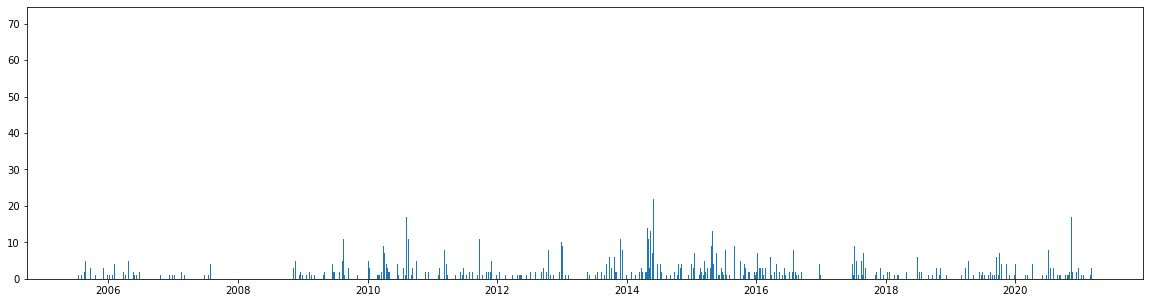

In [4]:
pdCommits = pd.read_sql_query("SELECT * FROM commits", db)

days = {(min_date+timedelta(days=x)).date() : 0 for x in range((max_date-min_date).days + 1)}

commit_dates = pdCommits['committer_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date()).value_counts()

for key in commit_dates.keys():
    days[key] = commit_dates.get(key)

keys = days.keys()
values = days.values()
plt.figure(figsize=(20,5))
plt.bar(keys, values)

## Bipartite networks
### Converting bipartite network into WOMP (weighted one-mode projection)

In [41]:
def collab_network(sqlite_db_file, git_repo_dir, t, node_info, min_date, max_date, file_base=True):
    if file_base:
        start = int(datetime.timestamp(min_date))
        end = int(datetime.timestamp(max_date))

        n = pp.Network.from_temporal_network(t, min_time=start, max_time=end)
        
        n = remove_duplicate_filenames(n, git_repo_dir)
        n = add_weights(n, node_info)
        
        new_n = copy.deepcopy(n)

        for node1 in n.nodes:
            if node_info['class'][node1] == 'author':
                for node2 in n.nodes:
                    if node_info['class'][node2] == 'author' and node1 != node2:
                        intersect = n.successors[node1].intersection(n.successors[node2])
                        w = 0
                        for file in intersect:
                            #print((node1, file), ':', n.edges[(node1, file)])
                            w = w + n.edges[(node1, file)]['wijLR']
                        if w > 0:
                            new_n.add_edge(node1, node2, weight=w)

        for node in n.nodes:
            if node_info['class'][node] == 'file':
                new_n.remove_node(node)

        return new_n
    else:
        n, node_info, edge_info = git2net.get_coauthorship_network(sqlite_db_file, time_from=min_date, time_to=max_date)
        return n

Funtion for removing file names from a network, which occur more than once in the given git repo. This is necessary because files that are named the same but are located in different folders are merged during the git2net network creation.

In [38]:
def remove_duplicate_filenames(n, git_repo_dir):
    all_files = []
    for path, subdirs, files in os.walk(git_repo_dir):
        for name in files:
            all_files.append(name)

    duplicates = [file for file in all_files if all_files.count(file) > 1]
    remove_files = set(duplicates)

    new_n = copy.deepcopy(n)
    for node in new_n.nodes:
        if node in remove_files:
            n.remove_node(node)
    del new_n
    return n

This function adds the total resources to the nodes, and the proportions to the edges.

In [39]:
def add_weights(n, node_info):
    for node in n.nodes:
        if node_info['class'][node] == 'author':
            s = 0
            for successor in n.successors[node]:
                for key in n.edges:
                    if key[0] == node and key[1] == successor:
                        s = s + n.edges[key]['weight']

        n.nodes[node]['WiL'] = s
    for edge in n.edges:
        n.edges[edge]['wijLR'] = n.edges[edge]['weight'] / n.nodes[edge[0]]['WiL']
    
    return n

In [40]:
t, node_info, edge_info = git2net.get_bipartite_network(sqlite_db_file)
n1 = collab_network(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2015, 12, 31), True)
n2 = collab_network(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 12, 31), True)
n3 = collab_network(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 6, 30), True)
n4 = collab_network(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 3, 31), True)
n5 = collab_network(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 1, 31), True)
n6 = collab_network(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 1, 8), True)

In [106]:
def collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, min_date, max_date, file_base=True):
    if file_base:
        start = int(datetime.timestamp(min_date))
        end = int(datetime.timestamp(max_date))

        n = pp.Network.from_temporal_network(t, min_time=start, max_time=end)
        
        n = remove_duplicate_filenames(n, git_repo_dir)
        
        new_n = copy.deepcopy(n)
        
        for node in n.nodes:
            if node_info['class'][node] == 'file':
                new_n.remove_node(node)
        
        new_n = new_n.to_undirected()
        visited_nodes = []
        for node1 in n.nodes:
            if node_info['class'][node1] == 'author':
                for node2 in n.nodes:
                    if node_info['class'][node2] == 'author' and node1 != node2 and not node2 in visited_nodes:
                        intersect = n.successors[node1].intersection(n.successors[node2])
                        w_min = 0
                        w_max = 0
                        for file in intersect:
                            #print((node1, file), ':', n.edges[(node1, file)])
                            w_min = w_min + min(n.edges[(node1, file)]['weight'], n.edges[(node2, file)]['weight'])
                            w_max = w_max + max(n.edges[(node1, file)]['weight'], n.edges[(node2, file)]['weight'])
                        if w_max > 0:
                            new_n.add_edge(node1, node2, weight=w_min/w_max)
                visited_nodes.append(node1)
                            
        return new_n
    else:
        n, node_info, edge_info = git2net.get_coauthorship_network(sqlite_db_file, time_from=min_date, time_to=max_date)
        return n

In [107]:
t, node_info, edge_info = git2net.get_bipartite_network(sqlite_db_file)
nj1 = collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2015, 12, 31), True)
nj2 = collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 12, 31), True)
nj3 = collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 6, 30), True)
nj4 = collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 3, 31), True)
nj5 = collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 1, 31), True)
nj6 = collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 1, 8), True)

In [108]:
nj3

In [116]:
style = {
    'edge_arrows': False,
    #'node_size': {v: 3+u['WiL'] for v,u in n.nodes.items()},
    'edge_width': {v: u['weight'] for v,u in nj3.edges.items()},
    'width': 600,
    'height': 600,
    'label_size': '9px',
}
pp.visualisation.plot(nj3, **style)

{('18', '54'): {'weight': 1.0},
 ('54', '70'): {'weight': 1.0},
 ('1', '18'): {'weight': 1.0},
 ('1', '55'): {'weight': 1.0},
 ('1', '59'): {'weight': 1.0},
 ('1', '63'): {'weight': 1.0},
 ('1', '14'): {'weight': 1.0},
 ('1', '65'): {'weight': 1.0},
 ('1', '66'): {'weight': 1.0},
 ('1', '67'): {'weight': 1.0},
 ('1', '74'): {'weight': 1.0},
 ('1', '81'): {'weight': 1.0},
 ('1', '83'): {'weight': 1.0},
 ('1', '89'): {'weight': 1.0},
 ('18', '55'): {'weight': 1.0},
 ('18', '57'): {'weight': 1.0},
 ('18', '59'): {'weight': 1.0},
 ('18', '62'): {'weight': 1.0},
 ('18', '63'): {'weight': 1.0},
 ('14', '18'): {'weight': 1.0},
 ('18', '65'): {'weight': 1.0},
 ('18', '66'): {'weight': 1.0},
 ('18', '67'): {'weight': 1.0},
 ('18', '70'): {'weight': 1.0},
 ('18', '74'): {'weight': 1.0},
 ('18', '79'): {'weight': 1.0},
 ('18', '80'): {'weight': 1.0},
 ('18', '83'): {'weight': 1.0},
 ('18', '89'): {'weight': 1.0},
 ('55', '62'): {'weight': 1.0},
 ('55', '63'): {'weight': 1.0},
 ('55', '67'): {'wei

### Network statistics

In [75]:
def network_stats(n, directed=False):
    d = {}
    N = len(n.nodes)
    
    # Node count
    d['N'] = N
    
    # Network density
    d['Network density'] = len(n.edges) / (N * (N - 1)) if N > 1 else 0
    
    # Clustering coefficient
    d['Clustering coeff.'] = pp.algorithms.statistics.avg_clustering_coefficient(n)
    
    # COnnected components
    try:
        d['Number of Components'] = len(pp.algorithms.components.connected_components(n))
    except ValueError:
        d['Number of Components'] = -1
    #d['Connected Components'] = pp.algorithms.components.connected_components(n)
    
    # Average degree
    if directed:
        d['Mean degree'] = pp.algorithms.statistics.mean_degree(n, degree='indegree')
    else:
        d['Mean degree'] = pp.algorithms.statistics.mean_degree(n, degree='degree')
    #d['Mean outdegree'] = pp.algorithms.statistics.mean_degree(n, degree='indegree')
    return d

#print(network_stats(n1))

Plotting the degree distribution

### Network statistics over time plots

In [81]:
#stats = network_stats(n1)
#stats

db = sqlite3.connect(sqlite_db_file)
max_date = datetime.strptime(pd.read_sql_query("SELECT max(committer_date) as max FROM commits", db)['max'].item(), '%Y-%m-%d %H:%M:%S')
#min_date = datetime.strptime(pd.read_sql_query("SELECT min(committer_date) as min FROM commits", db)['min'].item(), '%Y-%m-%d %H:%M:%S')
min_date = datetime.strptime('2014-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')

print('Min date: ', min_date)
print('Max date: ', max_date)

t, node_info, edge_info = git2net.get_bipartite_network(sqlite_db_file)

timespan = timedelta(days=30) # Timespan to be considered for the stats
days = {(min_date+timedelta(days=x)).date() : 0 for x in range((max_date-min_date-timespan).days + 1)}
x, yj1, yj2, yj3, yj4, yj5 = [], [], [], [], [], []

for day in days:
    print(day.strftime('%Y-%m-%d'))
    x.append(day)
    start = datetime.combine(day, datetime.min.time())
    end = datetime.combine(day+timespan, datetime.min.time())
    #n = collab_network(sqlite_db_file, git_repo_dir, t, node_info, day, day+timespan, True)
    n = collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, start, end, True)
    stats=network_stats(n)
    yj1.append(stats['N'])
    yj2.append(stats['Network density'])
    yj3.append(stats['Clustering coeff.'])
    yj4.append(stats['Number of Components'])
    yj5.append(stats['Mean degree'])



Min date:  2014-01-01 00:00:00
Max date:  2021-03-08 21:19:46
2014-01-01
2014-01-02
2014-01-03
2014-01-04
2014-01-05
2014-01-06
2014-01-07
2014-01-08
2014-01-09
2014-01-10
2014-01-11
2014-01-12
2014-01-13
2014-01-14
2014-01-15
2014-01-16
2014-01-17
2014-01-18
2014-01-19
2014-01-20
2014-01-21
2014-01-22
2014-01-23
2014-01-24
2014-01-25
2014-01-26
2014-01-27
2014-01-28
2014-01-29
2014-01-30
2014-01-31
2014-02-01
2014-02-02
2014-02-03
2014-02-04
2014-02-05
2014-02-06
2014-02-07
2014-02-08
2014-02-09
2014-02-10
2014-02-11
2014-02-12
2014-02-13
2014-02-14
2014-02-15
2014-02-16
2014-02-17
2014-02-18
2014-02-19
2014-02-20
2014-02-21
2014-02-22
2014-02-23
2014-02-24
2014-02-25
2014-02-26
2014-02-27
2014-02-28
2014-03-01
2014-03-02
2014-03-03
2014-03-04
2014-03-05
2014-03-06
2014-03-07
2014-03-08
2014-03-09
2014-03-10
2014-03-11
2014-03-12
2014-03-13
2014-03-14
2014-03-15
2014-03-16
2014-03-17
2014-03-18
2014-03-19
2014-03-20
2014-03-21
2014-03-22
2014-03-23
2014-03-24
2014-03-25
2014-03-26
201

2016-01-14
2016-01-15
2016-01-16
2016-01-17
2016-01-18
2016-01-19
2016-01-20
2016-01-21
2016-01-22
2016-01-23
2016-01-24
2016-01-25
2016-01-26
2016-01-27
2016-01-28
2016-01-29
2016-01-30
2016-01-31
2016-02-01
2016-02-02
2016-02-03
2016-02-04
2016-02-05
2016-02-06
2016-02-07
2016-02-08
2016-02-09
2016-02-10
2016-02-11
2016-02-12
2016-02-13
2016-02-14
2016-02-15
2016-02-16
2016-02-17
2016-02-18
2016-02-19
2016-02-20
2016-02-21
2016-02-22
2016-02-23
2016-02-24
2016-02-25
2016-02-26
2016-02-27
2016-02-28
2016-02-29
2016-03-01
2016-03-02
2016-03-03
2016-03-04
2016-03-05
2016-03-06
2016-03-07
2016-03-08
2016-03-09
2016-03-10
2016-03-11
2016-03-12
2016-03-13
2016-03-14
2016-03-15
2016-03-16
2016-03-17
2016-03-18
2016-03-19
2016-03-20
2016-03-21
2016-03-22
2016-03-23
2016-03-24
2016-03-25
2016-03-26
2016-03-27
2016-03-28
2016-03-29
2016-03-30
2016-03-31
2016-04-01
2016-04-02
2016-04-03
2016-04-04
2016-04-05
2016-04-06
2016-04-07
2016-04-08
2016-04-09
2016-04-10
2016-04-11
2016-04-12
2016-04-13

2018-01-30
2018-01-31
2018-02-01
2018-02-02
2018-02-03
2018-02-04
2018-02-05
2018-02-06
2018-02-07
2018-02-08
2018-02-09
2018-02-10
2018-02-11
2018-02-12
2018-02-13
2018-02-14
2018-02-15
2018-02-16
2018-02-17
2018-02-18
2018-02-19
2018-02-20
2018-02-21
2018-02-22
2018-02-23
2018-02-24
2018-02-25
2018-02-26
2018-02-27
2018-02-28
2018-03-01
2018-03-02
2018-03-03
2018-03-04
2018-03-05
2018-03-06
2018-03-07
2018-03-08
2018-03-09
2018-03-10
2018-03-11
2018-03-12
2018-03-13
2018-03-14
2018-03-15
2018-03-16
2018-03-17
2018-03-18
2018-03-19
2018-03-20
2018-03-21
2018-03-22
2018-03-23
2018-03-24
2018-03-25
2018-03-26
2018-03-27
2018-03-28
2018-03-29
2018-03-30
2018-03-31
2018-04-01
2018-04-02
2018-04-03
2018-04-04
2018-04-05
2018-04-06
2018-04-07
2018-04-08
2018-04-09
2018-04-10
2018-04-11
2018-04-12
2018-04-13
2018-04-14
2018-04-15
2018-04-16
2018-04-17
2018-04-18
2018-04-19
2018-04-20
2018-04-21
2018-04-22
2018-04-23
2018-04-24
2018-04-25
2018-04-26
2018-04-27
2018-04-28
2018-04-29
2018-04-30

2020-02-14
2020-02-15
2020-02-16
2020-02-17
2020-02-18
2020-02-19
2020-02-20
2020-02-21
2020-02-22
2020-02-23
2020-02-24
2020-02-25
2020-02-26
2020-02-27
2020-02-28
2020-02-29
2020-03-01
2020-03-02
2020-03-03
2020-03-04
2020-03-05
2020-03-06
2020-03-07
2020-03-08
2020-03-09
2020-03-10
2020-03-11
2020-03-12
2020-03-13
2020-03-14
2020-03-15
2020-03-16
2020-03-17
2020-03-18
2020-03-19
2020-03-20
2020-03-21
2020-03-22
2020-03-23
2020-03-24
2020-03-25
2020-03-26
2020-03-27
2020-03-28
2020-03-29
2020-03-30
2020-03-31
2020-04-01
2020-04-02
2020-04-03
2020-04-04
2020-04-05
2020-04-06
2020-04-07
2020-04-08
2020-04-09
2020-04-10
2020-04-11
2020-04-12
2020-04-13
2020-04-14
2020-04-15
2020-04-16
2020-04-17
2020-04-18
2020-04-19
2020-04-20
2020-04-21
2020-04-22
2020-04-23
2020-04-24
2020-04-25
2020-04-26
2020-04-27
2020-04-28
2020-04-29
2020-04-30
2020-05-01
2020-05-02
2020-05-03
2020-05-04
2020-05-05
2020-05-06
2020-05-07
2020-05-08
2020-05-09
2020-05-10
2020-05-11
2020-05-12
2020-05-13
2020-05-14

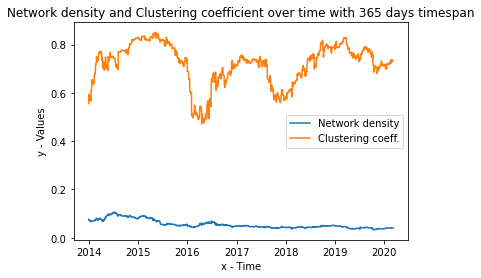

In [78]:
plt.plot(x, y2, label = "Network density")
plt.plot(x, y3, label = "Clustering coeff.")
plt.xlabel('x - Time')
plt.ylabel('y - Values')
plt.title('Network density and Clustering coefficient over time with 365 days timespan')
plt.legend()
plt.show()

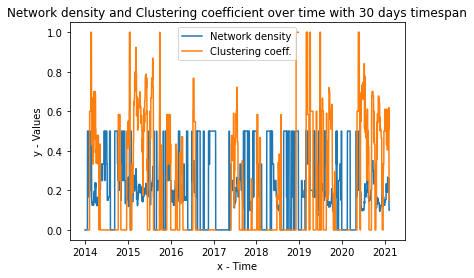

In [83]:
plt.plot(x, yj2, label = "Network density")
plt.plot(x, yj3, label = "Clustering coeff.")
plt.xlabel('x - Time')
plt.ylabel('y - Values')
plt.title('Network density and Clustering coefficient over time with 30 days timespan')
plt.legend()
plt.show()

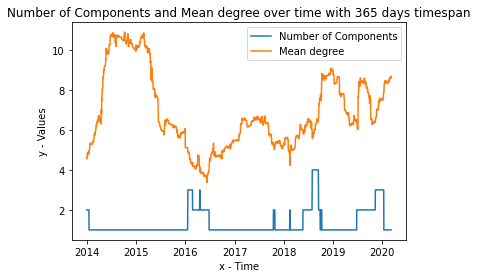

In [79]:
plt.plot(x, y4, label = "Number of Components")
plt.plot(x, y5, label = "Mean degree")
plt.xlabel('x - Time')
plt.ylabel('y - Values')
plt.title('Number of Components and Mean degree over time with 365 days timespan')
plt.legend()
plt.show()

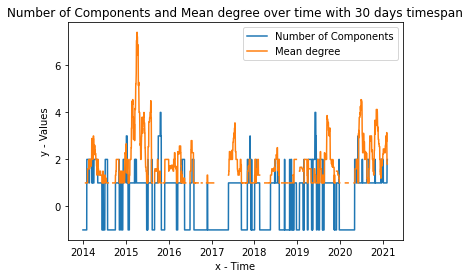

In [89]:
plt.plot(x, yj4, label = "Number of Components")
plt.plot(x, yj5, label = "Mean degree")
plt.xlabel('x - Time')
plt.ylabel('y - Values')
plt.title('Number of Components and Mean degree over time with 30 days timespan')
plt.legend()
plt.show()

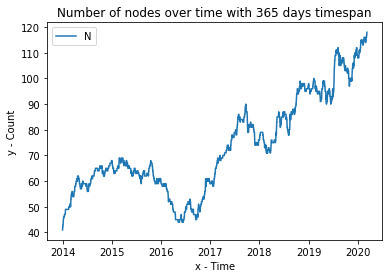

In [12]:
plt.plot(x, y1, label = "N")
plt.xlabel('x - Time')
plt.ylabel('y - Count')
plt.title('Number of nodes over time with 365 days timespan')
plt.legend()
plt.show()

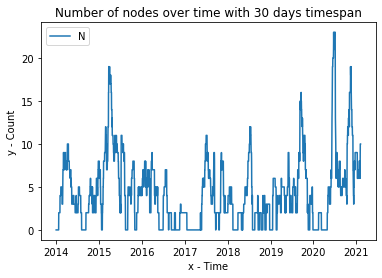

In [90]:
plt.plot(x, y1, label = "N")
plt.xlabel('x - Time')
plt.ylabel('y - Count')
plt.title('Number of nodes over time with 30 days timespan')
plt.legend()
plt.show()

In [456]:
help(pp.algorithms.statistics)

Help on module pathpy.algorithms.statistics in pathpy.algorithms:

NAME
    pathpy.algorithms.statistics - Collection of statistical measures for  paths, (higher-order) networks, and temporal networks

FUNCTIONS
    avg_clustering_coefficient(network)
        Calculates the average (global) clustering coefficient of a directed or undirected network.
        
        Parameters
        ----------
        network:    Network
            The network in which to calculate the local clustering coefficient.
    
    degree_dist(network, degree='degree')
        Calculates the (in/out)-degree distribution of a directed or undirected network.
        
        Parameters
        ----------
        network:    Network
            The network for which to calculate the degree distribution
    
    degree_moment(network, k, degree='degree')
        Calculates the k-th moment of the (in/out)-degree distribution of a
        directed or undirected network.
        
        Parameters
        -------

## Export temporal networks into HTML

In [ ]:
def export_networks(git_repo_dir, t, node_info, sqlite_db_file, time_from, time_to, interval, delta, file_mode, repo_name):
    if len(time_from) == len(time_to) == len(interval) == len(delta) == len(file_mode):
        for i in range(0,len(delta)-1):
            print('\nIteration {i}/{r}'.format(i=i+1, r=len(delta)))
            t2 = pp.TemporalNetwork()
            current_interval = timedelta(days=interval[i])
            current_delta = timedelta(days=delta[i])
            rounds = math.ceil((time_to[i] - time_from[i] - current_interval)/current_delta)
            for j in range(1,rounds+1):
                print('Round {j}/{r}'.format(j=j, r=rounds), end = "\r")
                start = time_from[i] + j * current_delta
                end = time_from[i] + j * current_delta + current_interval
                network = collab_network(sqlite_db_file, git_repo_dir, t, node_info, start, end, file_mode[i])

                for edge in network.edges:
                    edge_from = "{:.0f}".format(edge[0]) if type(edge[0]) is float or type(edge[0]) is int else edge[0]
                    edge_to   = "{:.0f}".format(edge[1]) if type(edge[1]) is float or type(edge[1]) is int else edge[1]
                    t2.add_edge(edge_from, edge_to, j)

            style = {    
              'ts_per_frame': 1, 
              'ms_per_frame': 700,
              'look_ahead': 0, 
              'look_behind': 1, 
              'inactive_edge_width': 2,
              'active_edge_width': 4, 
              'label_color' : '#000000',
              'label_size' : '8px',
              'label_offset': [0,5]
              }
            pp.visualisation.export_html(t2, 'exports/{r}/{r}_tf{tf}_tt{tt}_i{i}_d{d}_{f}.html'.format(
                r=repo_name,
                tf=time_from[i].strftime('%Y%m%d'),
                tt=time_to[i].strftime('%Y%m%d'),
                i=interval[i],
                d=delta[i],
                f='f' if file_mode[i] else 'l'
            ), **style)
    else:
        raise ValueError
    print('\nFinished exporting!')

In [ ]:
time_from = [datetime(2014, 4,  1), datetime(2014, 4, 1), datetime(2014, 4,  1), datetime(2014,  1,  1), datetime(2014,  1,  1), datetime(2014,  1,  1), datetime(2014,  1,  1)]
time_to   = [datetime(2014, 4, 30), datetime(2014, 5, 6), datetime(2014, 5, 13), datetime(2014, 12, 31), datetime(2014, 12, 31), datetime(2015, 12, 31), datetime(2016, 12, 31)]
interval  = [1, 7, 14, 30, 60, 30, 60]
delta     = [1, 1,  1,  7,  7, 14, 14]
file_mode = [False, False, False, False, False, False, False]

export_networks(git_repo_dir, t, node_info, sqlite_db_file, time_from, time_to, interval, delta, file_mode, repo_name)